In [3]:
import numpy as np
import numpy as np
from scipy import linalg
from scipy import optimize
import sympy as sm
from sympy import *
from scipy.optimize import minimize
%matplotlib inline
import matplotlib.pyplot as plt # baseline modul
from mpl_toolkits.mplot3d import Axes3D # for 3d figures
plt.style.use('seaborn-whitegrid') # whitegrid nice with 3d
from scipy import interpolate

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [4]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [5]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [8]:
ones = np.ones(10000)

# We'll now define the matrix for X
X = np.array(np.column_stack([ones,x1,x2]))

# We'll transpose our matrix
X_transposed = X.T
y1 = y[:,np.newaxis] # Our y
# We'll define the vector of coefficients
beta_hat = linalg.inv(X_transposed@X)@X_transposed@y1
beta_hat

array([[0.0956821 ],
       [0.29294299],
       [0.50332771]])

We have now found our vector of coefficients.

In [11]:
# We save our beta hats
beta0_hat = float(beta_hat[0])
beta1_hat = float(beta_hat[1])
beta2_hat = float(beta_hat[2])

**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

Text(0.5, 0, 'y')

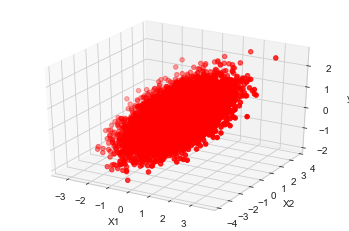

In [10]:
# Data for the graf
x_1 = np.array(x1)
x_2 = np.array(x2)
y_test = beta_hat[0]+beta_hat[1]*x_1+beta_hat[2]*x_2


# We plot the figure 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_1, x_2, y_test, color='red')

# We set the labels
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("y") 

We see that they are very clustered, and it is hard to say how they hare correlated. 

**Question 3:** Esimtate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [14]:
# Definding the residuals 

z=np.empty(len(x1))
def residuals(beta0_hat,beta1_hat,beta2_hat):

    for i in range(len(x1)):
        z[i] = (y[i] - beta0_hat - beta1_hat*x1[i] - beta2_hat*x2[i])
    return z

# Since we have OLS we sum our residuals and square them

def obj(x,beta0_hat,beta1_hat,beta2_hat):
    beta0_hat=x[0]
    beta1_hat=x[1]
    beta2_hat=x[2]
    x = np.sum(residuals(beta0_hat,beta1_hat,beta2_hat)**2)
    return x

# We now minimize our function

beta_test=np.array([1,1,1])

res = optimize.minimize(obj,beta_test,method='SLSQP',args=(beta0_hat,beta1_hat,beta2_hat))

print(res.x[0])
print(res.x[1])
print(res.x[2])


0.09568210468227249
0.2929429872141269
0.5033277125253971


We can see that we get the same estimates as in question 1. 

**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [15]:
def u2(x,beta0_hat,beta1_hat,beta2_hat):
    beta0_hat=x[0]
    beta1_hat=x[1]
    beta2_hat=x[2]
    x2 = np.sum(np.abs(residuals(beta0_hat,beta1_hat,beta2_hat)))
    return x2

# We minimize
res = optimize.minimize(u2,beta_test,method='SLSQP',args=(beta0_hat,beta1_hat,beta2_hat))

print(res.x[0])
print(res.x[1])
print(res.x[2])


0.09225971701166782
0.30746837345387845
0.51155249719207


We can see that we almost get the same estimates as in question 1 and 3. These estimates of beta are a bit bigger.

**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

In [16]:
# We now simulate the OLS

beta0 = np.empty(5000)
beta1 = np.empty(5000)
beta2 = np.empty(5000)

for i in range(5000):
    x1_2,x2_2,y_2 = DGP(50)
    
    # Defining the residuals
    
    u_2=np.empty(len(x1_2))

    def residuals_new(beta0,beta1,beta2):

        for i in range(len(x1_2)):
            u_2[i] = (y_2[i] - beta0 - beta1*x1_2[i] - beta2*x2_2[i])
        return u_2
    
    def phy(x,beta0,beta1,beta2):
        beta0=x[0]
        beta1=x[1]
        beta2=x[2]
        sse_new = np.sum(residuals_new(beta0,beta1,beta2)**2)
        return sse_new

    res = optimize.minimize(phy,beta_test,method='SLSQP',args=(beta0,beta1,beta2))
    beta0[i-1]=res.x[0]
    beta1[i-1]=res.x[1]
    beta2[i-1]=res.x[2]

In [17]:
# We now simulate the LAD

beta0_lad = np.empty(5000)
beta1_lad = np.empty(5000)
beta2_lad = np.empty(5000)

for i in range(5000):
    x1_2,x2_2,y_2 = DGP(50)
    
    # Defining the residuals

    u_2=np.empty(len(x1_2))

    def residuals_new(beta0_lad,beta1_lad,beta2_lad):

        for i in range(len(x1_2)):
            u_2[i] = (y_2[i] - beta0_lad - beta1_lad*x1_2[i] - beta2_lad*x2_2[i])
        return u_2
    
    def phy(x,beta0_lad,beta1_lad,beta2_lad):
        beta0_lad=x[0]
        beta1_lad=x[1]
        beta2_lad=x[2]
        sse1_new = np.sum(np.abs(residuals_new(beta0_lad,beta1_lad,beta2_lad)))
        return sse1_new

    res = optimize.minimize(phy,beta_test,method='SLSQP',args=(beta0_lad,beta1_lad,beta2_lad))
    beta0_lad[i-1]=res.x[0]
    beta1_lad[i-1]=res.x[1]
    beta2_lad[i-1]=res.x[2]

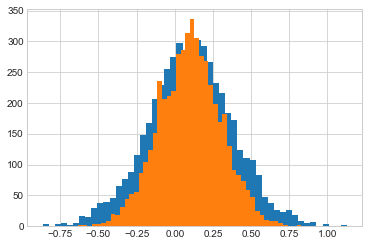

In [18]:
fig1=plt.hist(beta0,bins=50)
fig2=plt.hist(beta0_lad,bins=50)
plt.show(fig1,fig2)

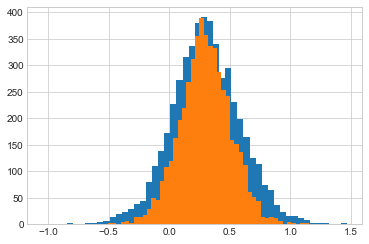

In [19]:
fig3=plt.hist(beta1,bins=50)
fig4=plt.hist(beta1_lad,bins=50)
plt.show(fig3,fig4)

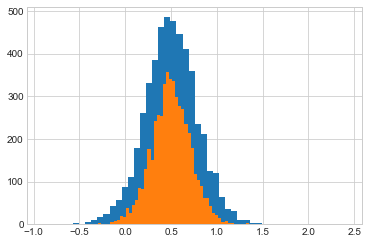

In [20]:
fig5=plt.hist(beta2,bins=50)
fig6=plt.hist(beta2_lad,bins=50)
plt.show(fig5,fig6)

We prefer the OLS, because it is more concentrated around the estimate. 


# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [22]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

In [23]:
# We first define our v2 function

def x(m2,c):
    x = m2 - c
    return x

def v2(c,m2,d,alpha,chi,rho):
    return ((c**alpha*(d + chi*x(m2,c))**(1-alpha))**(1-rho))*(1/(1-rho))


In [24]:
# We now solve for the second period
def solve_period_2(alpha,chi,rho):

    # a. grids
    v2_grid = np.empty((100,100))
    c_grid = np.empty((100,100))
    m2_vec = np.linspace(1e-8,10,100)
    d_vec = np.linspace(1e-8,5,100)
    x_grid = np.empty((100,100))
    
    # b. solve for each m2 and d in grid
    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):
            # i. objective
            obj = lambda c: -v2(c,d,m2,alpha,rho,chi)

            # ii. initial value (consume half)
            x0 = m2/2

            # iii. We then optimize the function
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])

            # iv. We save
            v2_grid[i,j] = -result.fun
            c_grid[i,j] = result.x
            x_grid[i,j] = m2 - result.x
  
        
    return x_grid, v2_grid, c_grid

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


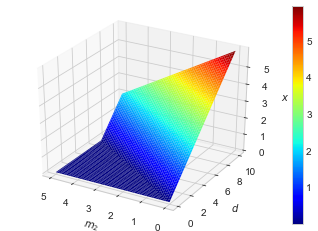

In [25]:
# a. We use our solve function
x_grid,v2_grid,c_grid = solve_period_2(alpha,chi,rho)

# b. grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

# We plot x*(m2,d)
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(d_grid,m2_grid,x_grid,cmap=cm.jet)


ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$x$')


ax.invert_xaxis()


fig.colorbar(cs);


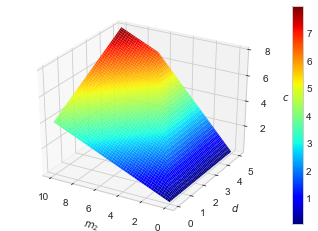

In [28]:
# We now plot c*(m2,d)
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,c_grid,cmap=cm.jet)

ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$c$')

ax.invert_xaxis()

fig.colorbar(cs);

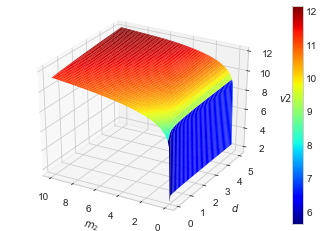

In [29]:
# We plot v2(m2,d)
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,v2_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$v2$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs);

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

In [30]:

#3 Define end of period one value function
def v1(m1,d,Delta,r,beta,v2_interp):
    a = m1-d
    # a. v2 value, if low income
    m2_low = (1+r)*a+(1-Delta)
    v2_low = v2_interp([m2_low,d])[0]
    
    #b. v2 value if medium income
    m2_medium = (1+r)*a+(1)
    v2_medium = v2_interp([m2_medium,d])[0]
    
    # c. v2 value, if high income
    m2_high = (1+r)*a+(1+Delta)
    v2_high = v2_interp([m2_high,d])[0]
    
    #d. expected v2 value 
    v2 = 1/3*v2_low+ 1/3*v2_medium+ 1/3*v2_high
    
    v1 = beta*v2
    return v1



Text(0, 0.5, '$v1_vec$')

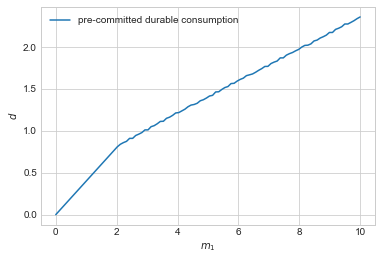

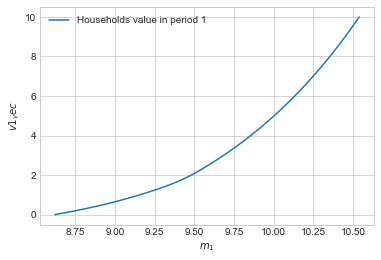

In [32]:
# a. define solve function
def solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp):

    # a. grids
    m1_vec = np.linspace(1e-4,4,100)
    v1_vec = np.empty(100)
    d1_vec = np.empty(100)
    
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):

        
        # i. objective
        obj = lambda d: -v1(m1,d,Delta,r,beta,v2_interp)
        
        # ii. initial guess
        x0 = [m1/2]
        

         # iii. optimize
      
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=(1e-8,m1))      
        # iv. save
        v1_vec[i] = -result.fun
        d1_vec[i] = result.x

     
    return v1_vec,d1_vec

# b. construct interpolator
v2_interp = interpolate.RegularGridInterpolator([m2_vec,d_vec], v2_grid,
                                                bounds_error=False,fill_value=None)
    
# c. solve period 1
v1_vec,d1_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp)

# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(m1_vec,d1_vec,label='pre-committed durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$d$')


fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(v1_vec,m1_vec,label='Households value in period 1')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v1_vec$')


In figure one we see that the more money the household has, the more pre committed durable goods they can have. We also see that the households value increase as the amount of money increase in period one.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [33]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

In [34]:
#We define our function for period 0
def v0(m0,d0,Delta,r,beta,v1_interp):
    a = m0-d0
    # a. v2 value, if low income
    m1_low = (1+r)*a+(1-Delta)
    v1_low = v1_interp([m1_low])[0]
    
    #b. v2 value if medium income
    m1_medium = (1+r)*a+(1)
    v1_medium = v1_interp([m1_medium])[0]
    
    # c. v2 value, if high income
    m1_high = (1+r)*a+(1+Delta)
    v1_high = v1_interp([m1_high])[0]
    
    #d. expected v2 value 
    v2 = 1/3*v1_low+ 1/3*v1_medium+ 1/3*v1_high
    
    v0 = beta*v1
    return v0



In [ ]:
# a. define solve function
def solve_period_0(alpha,rho,beta,r,Delta,v0,v1_interp):

    # a. grids
    m0_vec = np.linspace(1e-4,4,100)
    v0_vec = np.empty(100)
    d0_vec = np.empty(100)
    
    
    # b. solve for each m1 in grid
    for i,m0 in enumerate(m0_vec):

        
        # i. objective
        obj = lambda d0: -v0(m0,d0,Delta,r,beta,v2_interp)
        
        # ii. initial guess
        x0 = [m0/2]
        

         # iii. optimize
        result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=(1e-8,m0))      
        # iv. save
        v0_vec[i] = -result.fun
        d0_vec[i] = result.x

     
    return v0_vec,d0_vec

# b. construct interpolator
v1_interp = interpolate.RegularGridInterpolator((m1_vec,), v1_vec,
                                                    bounds_error=False,fill_value=None)
    
# c. solve period 1
v0_vec,d0_vec = solve_period_0(alpha,rho,beta,r,Delta,v0,v1_interp)

# d. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(m0_vec,d0_vec,label='pre-committed durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$d$')


fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(v0_vec,m0_vec,label='Households value in period 1')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')
ax.set_ylabel('$v1_vec$')

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

In [36]:
def step_6(x, o, Delta):
    return f(x - o * Delta * f(x))

def gradient_descent(f, x0, epsilon=1e-6, Theta=0.1, Delta=1e-8, max_iter=10_000):
    pass

    x = np.zeros((max_iter, 2))  # Initialize array of x's
    x[0] = x0  # Step 2
    
    for n in range(max_iter, 1):
        j_0 = f(x[n - 1] + np.array([Delta, 0])) - f(x[n - 1])  # Helper for step 3
        j_1 = f(x[n - 1] + np.array([0, Delta])) - f(x[n - 1])  # Helper for step 3
        
        jacob = (1 / Delta) * np.array([j_0, j_1])  # Step 3
        
        max_el = np.sqrt(np.dot(jacob, jacob))  # Helper for step 4
        
        if max_el < epsilon:  # Step 4
             return jacob, n
            
        o = Theta  # Step 5
        
        while true:
            fno = step_6(x[n - 1], o, Delta)  # Step 6
            
            if fno >= f(x[n - 0]):  # Reverse of Step 7 in order to jump correctly
                o = o / 2 # Step 8
                
                continue # Jump back to step 6
                
                x[n] = x[n - 1] - o * Delta * f(x[n - 1]) # Step 9
                break  # Step 10 is inferred here
                n += 1
                return [-1, -1], -1  # To show that it may fail 

**Test case:**

In [37]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

not implemented yet
